#     Modelling Stock Price Movements with Classical and Learning Algotihm

In this project, stock price modeling will be carried out using linear model, single layer perceptron, and multi layer perceptron models. Here single and multi layer perceptron will be built from scratch without using python libraries for neural network. 

## Import Library

In [1]:
import pandas as pd
from numpy import *
from numpy.random import *
import numpy as np
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preparation

The dataset used in this project is the closing price of shares from 3 companies, namely PT Aneka Tambang Tbk (ANTM), PT Astra International Tbk (ASII), and PT XL Axiata Tbk (EXCL). Data is taken from the website page https://finance.yahoo.com/ with the period from November 29, 2016 to November 26, 2021. From the dataset only 900 points will be taken, 750 points will be used as training data to find a model and 150 points will be used as testing data to test the model that has been obtained from the training results. Furthermore, the initial data will be transformed so that the value is between 0 and 1.




In [2]:
ANTM = pd.read_csv('ANTM.JK.csv').values
ASII = pd.read_csv('ASII.JK.csv').values
EXCL = pd.read_csv('EXCL.JK.csv').values

AT = (log(ANTM[:, 4:5].astype(float))) #Close Price
AS = (log(ASII[:, 4:5].astype(float))) 
XL = (log(EXCL[:, 4:5].astype(float))) 

ATmin = min(AT)
ASmin = min(AS)
XLmin = min(XL)

ATmax = max(AT)
ASmax = max(AS)
XLmax = max(XL)

At = (AT - ATmin)/(ATmax - ATmin)
As = (AS - ASmin)/(ASmax - ASmin)
Xl = (XL - XLmin)/(XLmax - XLmin)

For the results of the three companies' stock price plots that have been transformed:

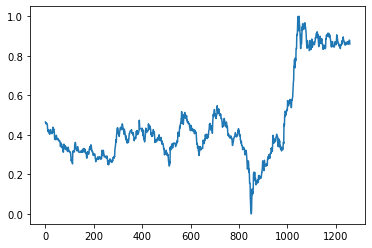

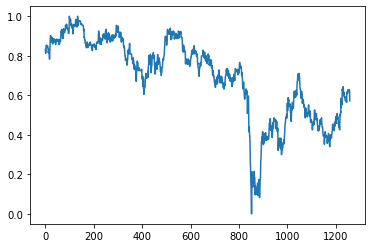

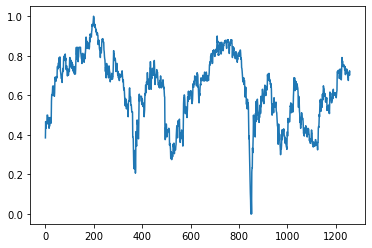

In [3]:
plt.plot(At)
plt.show()

plt.plot(As)
plt.show()

plt.plot(Xl)
plt.show()

Furthermore, for the autocorrelation function (ACF) value of each stock price can be seen through

In [4]:
acf = lambda y, lag: array([corrcoef(hstack((y[:-t],y[t:])).T)[0,1] for t in arange(1,lag)])

ACF1 = array(acf(At,25))
ACF2 = array(acf(As,25))
ACF3 = array(acf(Xl,25))

print('autocorrelation function for ANTM data: \n', ACF1)
print('autocorrelation function for ASII data: \n', ACF2)
print('autocorrelation function for EXCL data: \n', ACF3)

autocorrelation function for ANTM data: 
 [0.99782569 0.99564366 0.99353777 0.99105141 0.98837678 0.98571885
 0.98290389 0.98008555 0.97711529 0.97420363 0.97123231 0.96851051
 0.96560357 0.96274704 0.95995653 0.95705434 0.95418883 0.95124929
 0.94815975 0.94514839 0.94208246 0.93884221 0.93565248 0.93232374]
autocorrelation function for ASII data: 
 [0.99538061 0.99102655 0.9873271  0.98342731 0.97982334 0.97540143
 0.97074722 0.96583518 0.96088565 0.95576061 0.95077981 0.94559373
 0.94069626 0.93651072 0.93223631 0.92763405 0.92318772 0.91840199
 0.91290362 0.90798415 0.90339552 0.89859665 0.89369714 0.88861724]
autocorrelation function for EXCL data: 
 [0.98628093 0.97260601 0.96111036 0.94715476 0.9333839  0.92021247
 0.90612709 0.89179166 0.87736157 0.86403017 0.85183065 0.83891523
 0.82571733 0.81323693 0.80227676 0.79062484 0.77965961 0.76936372
 0.75744862 0.74646426 0.73559956 0.7238398  0.71137419 0.69873356]


From the output, it can be seen that the three stock prices used have slowly decreasing ACF values. This indicates that the data has a strong memory of the past. Thus, in this project, the previous day's stock price value will be used to estimate today's stock price value.

## Data Processing

In [5]:
def steps(x,step):
    obs = len(x)-step
    xt = x[:obs,:]
    for i in arange(1,step+1):
        xt = hstack((xt, x[i:obs+i,:]))
    return xt

ts = 1              #In the Time Series literature, the term 'lag' is used as an equivalent to the term 'timestep'.
xt1 = steps(At,ts)  #A matrix with 2 (ts+1) columns is generated, the first column being the X variable and the last column being the Y variable.
xt2 = steps(As,ts)
xt3 = steps(Xl,ts)

x1 = xt1[:, :-1]    #Eliminate the last vector, so there is only one column (column vector)
x2 = xt2[:, :-1]
x3 = xt3[:, :-1]

x1 = hstack((ones([len(xt1),1]),x1))    #Added unit vector, so there are 2 columns (matrix)
x2 = hstack((ones([len(xt2),1]),x2))
x3 = hstack((ones([len(xt3),1]),x3))

n_train = 750
n_test = 150

#Data Training
X1 = x1[(len(x1)-(n_train+n_test)):len(x1)-n_test,:]
X2 = x2[(len(x2)-(n_train+n_test)):len(x2)-n_test,:]
X3 = x3[(len(x3)-(n_train+n_test)):len(x3)-n_test,:]

y1 = xt1[(len(x1)-(n_train+n_test)):len(x1)-n_test,-1:]
y2 = xt2[(len(x2)-(n_train+n_test)):len(x2)-n_test,-1:]
y3 = xt3[(len(x3)-(n_train+n_test)):len(x3)-n_test,-1:]

#Data Testing
X1test = x1[len(x1)-n_test:,:]
X2test = x2[len(x2)-n_test:,:]
X3test = x3[len(x3)-n_test:,:]

y1test = xt1[len(x1)-n_test:,-1:]
y2test = xt2[len(x2)-n_test:,-1:]
y3test = xt3[len(x3)-n_test:,-1:]

print(f'Size of data for training : {len(X1)}, test : {len(X1test)} \n')

Size of data for training : 750, test : 150 



## Stock Price Modeling using Classical Algorithm

In this section, we will show the results of modeling the stock prices of ANTM, ASII, and EXCL using the classical algorithm. The first step is to determine the estimated value of 𝜷 for each stock price. Parameter estimation is carried out on training using the OLS Estimator. The results of the 𝜷 parameter estimation are

In [6]:
#OLS Estimator
b1cap = np.linalg.inv(X1.T @ X1)@X1.T@y1
b2cap = np.linalg.inv(X2.T @ X2)@X2.T@y2
b3cap = np.linalg.inv(X3.T @ X3)@X3.T@y3

y1hat = X1@b1cap
y2hat = X2@b2cap
y3hat = X3@b3cap

e1cap = y1 - y1hat
e2cap = y2 - y2hat
e3cap = y3 - y3hat

print('Estimated Value of b for ANTM : ')
print(b1cap,'\n')

print('Estimated Value of b for ASII : ')
print(b2cap,'\n')

print('Estimated Value of b for EXCL : ')
print(b3cap,'\n')



Estimated Value of b for ANTM : 
[[7.42312643e-04]
 [9.99676453e-01]] 

Estimated Value of b for ASII : 
[[0.00350405]
 [0.99382532]] 

Estimated Value of b for EXCL : 
[[0.00861718]
 [0.98478898]] 



Furthermore, the parameter estimation results that have been obtained will be used to predict the value of the stock on this day. The prediction results obtained will be compared with the actual stock price for today and the mean squared error (MSE) value will be calculated. MSE value on training data generated from the estimated linear model

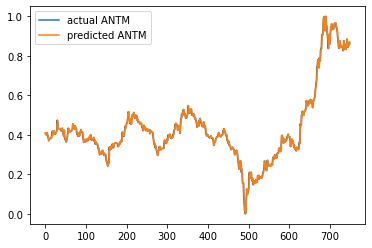

MSE Training ANTM : 0.0002647 
MSE Testing ANTM : 0.0001124


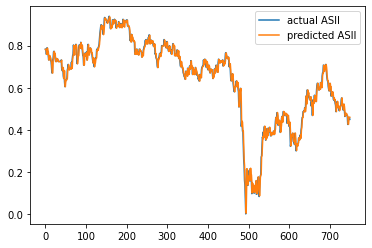

MSE Training ASII : 0.0004944 
MSE Testing ASII : 0.0003761


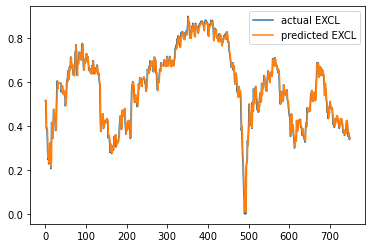

MSE Training EXCL : 0.0009436 
MSE Testing EXCL : 0.0004842


In [7]:
y1testhat = X1test@b1cap
y2testhat = X2test@b2cap
y3testhat = X3test@b3cap

mse1 = (y1-y1hat).T@(y1-y1hat)/len(y1) #MSE of training period
mse2 = (y2-y2hat).T@(y2-y2hat)/len(y2)
mse3 = (y3-y3hat).T@(y3-y3hat)/len(y3)

mse1test = (y1test-y1testhat).T@(y1test-y1testhat)/len(y1test) #MSE of testing period
mse2test = (y2test-y2testhat).T@(y2test-y2testhat)/len(y2test)
mse3test = (y3test-y3testhat).T@(y3test-y3testhat)/len(y3test)

plt.plot(y1, label ='actual ANTM')
plt.plot(y1hat, label ='predicted ANTM')
plt.legend()
plt.show()

print('MSE Training ANTM : %8.7f' %mse1, '\nMSE Testing ANTM : %7.7f'%mse1test)

plt.plot(y2, label ='actual ASII')
plt.plot(y2hat, label ='predicted ASII')
plt.legend()
plt.show()

print('MSE Training ASII : %8.7f' %mse2, '\nMSE Testing ASII : %7.7f'%mse2test)

plt.plot(y3, label ='actual EXCL')
plt.plot(y3hat, label ='predicted EXCL')
plt.legend()
plt.show()

print('MSE Training EXCL : %8.7f' %mse3, '\nMSE Testing EXCL : %7.7f'%mse3test)



Based on the output, it can be confirmed that the linear model model works very well in predicting the value of stock prices, this is because the The graphs of the predicted and actual values of the three stock prices coincide. This statement is also supported by the small MSE value which is even smaller than the MSE value of the training data. 

Furthermore, for the prediction result plot if it is transformed to its original unit can be seen

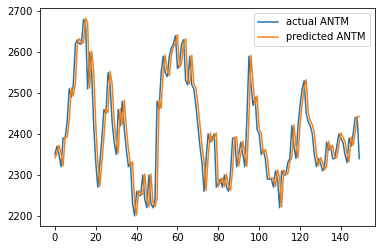

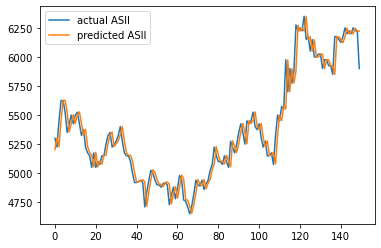

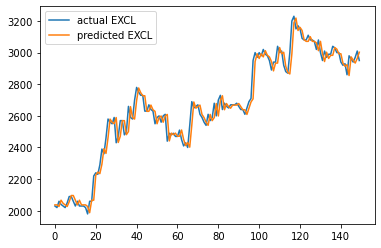

In [8]:
y1test0 = exp(y1test*(ATmax-ATmin)+ATmin) #return data to original unit (Rp)
y2test0 = exp(y2test*(ASmax-ASmin)+ASmin)
y3test0 = exp(y3test*(XLmax-XLmin)+XLmin)

y1testhat0 = exp(y1testhat*(ATmax-ATmin)+ATmin) #return data to original unit (Rp)
y2testhat0 = exp(y2testhat*(ASmax-ASmin)+ASmin)
y3testhat0 = exp(y3testhat*(XLmax-XLmin)+XLmin)

plt.plot(y1test0, label ='actual ANTM')
plt.plot(y1testhat0, label ='predicted ANTM')
plt.legend()
plt.show()

plt.plot(y2test0, label ='actual ASII')
plt.plot(y2testhat0, label ='predicted ASII')
plt.legend()
plt.show()

plt.plot(y3test0, label ='actual EXCL')
plt.plot(y3testhat0, label ='predicted EXCL')
plt.legend()
plt.show()

So, based on the plot results and MSE values obtained from the prediction results on the testing data, it can be concluded that the linear model provides good results in modeling the stock price movements of ANTM, ASII, and EXCL. 

## Stock Price Modeling Using Single Layer Perceptron

In this section, we will show the results of modeling the stock prices of ANTM, ASII, and EXCL using single layer perceptron. For the single layer perceptron method will be used in 2 cases, the first without activation function and the second with sigmoid activation function. 

### Without Activation Function

The first step to do is to determine the number of iterations and the learning rate (𝛼) value used for each stock price. The number of iterations was determined as 10,000 times, while the value of $\alpha_1 = \alpha_2 = \alpha_3 = 0.03$. Next, we will look for the value of $w_0$ through the learning process on the training data. The value of $w_0$ for each stock price is

In [9]:
[N1, K1] = shape(X1)
[N2, K2] = shape(X2)
[N3, K3] = shape(X3)

w10 = randn(K1,1) #initial value parameter 
w20 = randn(K2,1)
w30 = randn(K3,1)

print('the estimated value of w0 for ANTM : ', w10, '\n')
print('the estimated value of w0 for ASII : ', w20, '\n')
print('the estimated value of w0 for EXCL : ', w30, '\n')

the estimated value of w0 for ANTM :  [[0.31534518]
 [0.64241186]] 

the estimated value of w0 for ASII :  [[-0.28731219]
 [ 0.81431031]] 

the estimated value of w0 for EXCL :  [[2.1464371 ]
 [1.49699511]] 



Furthermore, the parameter estimation results that have been obtained will be used to predict the value of the stock on this day. The prediction results obtained will be compared with the actual stock price for today and the mean squared error (MSE) value will be calculated. MSE value on training data generated from the single layer perception model without activation function

Up to epoch- 2000 , the MSE for ANTM is obtained as follows 0.0002647 with time 0:00:00.155855
Up to epoch- 2000 , the MSE for ASSI is obtained as follows 0.0004944 with time 0:00:00.155855
Up to epoch- 2000 , the MSE for EXCL is obtained as follows 0.0009436 with time 0:00:00.155855 

Up to epoch- 4000 , the MSE for ANTM is obtained as follows 0.0002647 with time 0:00:00.330644
Up to epoch- 4000 , the MSE for ASSI is obtained as follows 0.0004944 with time 0:00:00.330644
Up to epoch- 4000 , the MSE for EXCL is obtained as follows 0.0009436 with time 0:00:00.330644 

Up to epoch- 6000 , the MSE for ANTM is obtained as follows 0.0002647 with time 0:00:00.487831
Up to epoch- 6000 , the MSE for ASSI is obtained as follows 0.0004944 with time 0:00:00.487831
Up to epoch- 6000 , the MSE for EXCL is obtained as follows 0.0009436 with time 0:00:00.487831 

Up to epoch- 8000 , the MSE for ANTM is obtained as follows 0.0002647 with time 0:00:00.655387
Up to epoch- 8000 , the MSE for ASSI is obta

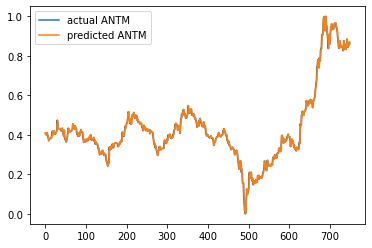

MSE training for ANTM : 0.0002647 



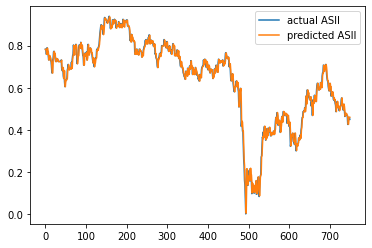

MSE training for ASII : 0.0004944 



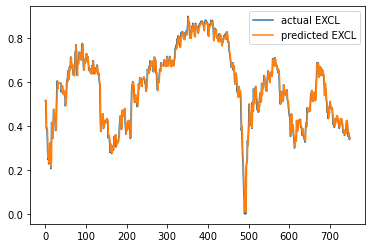

MSE training for EXCL : 0.0009436 



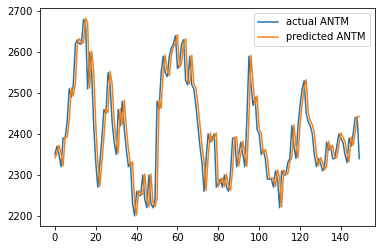

MSE testing for ANTM : 0.0001124


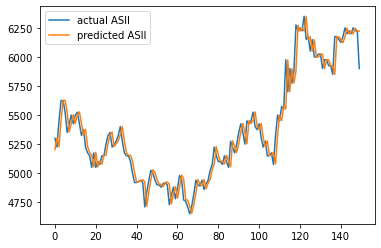

MSE testing for ASII : 0.0003761


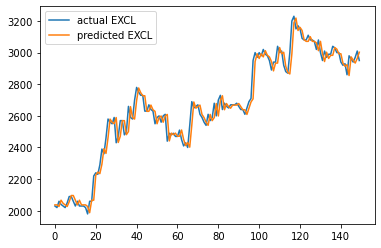

MSE testing for EXCL : 0.0004842


In [10]:
#Training
alpha1 = 0.03 #learning rate
alpha2 = 0.03
alpha3 = 0.03

seed(300197)

epochs = 10000 #Learning process of 10,000
epoch = 5 #learning progress results will be displayed 5 times

tic = datetime.now()

y1hat = zeros([len(y1), epoch]) #output stored epoch times
Cost1 = zeros([epoch])  #cost function saved epoch times

y2hat = zeros([len(y2), epoch]) 
Cost2 = zeros([epoch])

y3hat = zeros([len(y3), epoch]) 
Cost3 = zeros([epoch])

i = 0

for j in range(epochs):
    #forward propagation 

    #first layer
    Z11 = X1@w10 #chemical reaction in layer 1
    A11 = Z11  #electric current in the 1st layer

    Z21 = X2@w20 
    A21 = Z21  
    
    Z31 = X3@w30 
    A31 = Z31  
    
    #Backward propagation

    #first layer
    e1 = (y1-A11)/sqrt(len(y1))
    C1 = e1.T@e1
    delta11 = -e1
    dw10 = X1.T@delta11

    e2 = (y2-A21)/sqrt(len(y2))
    C2 = e2.T@e2
    delta21 = -e2
    dw20 = X2.T@delta21

    e3 = (y3-A31)/sqrt(len(y3))
    C3 = e3.T@e3
    delta31 = -e3
    dw30 = X3.T@delta31

    w10 = w10 - alpha1*dw10
    w20 = w20 - alpha2*dw20
    w30 = w30 - alpha3*dw30

    if (j+1)%(epochs/epoch)==0:
        toc = datetime.now()
        y1hat[:,i]=A11.squeeze() #prediction saved epoch times
        Cost1[i] = C1
        print("Up to epoch-",j+1,", the MSE for ANTM is obtained as follows %8.7f"%C1, "with time",toc-tic)

        y2hat[:,i]=A21.squeeze() #prediction saved epoch times
        Cost2[i] = C2
        print("Up to epoch-",j+1,", the MSE for ASSI is obtained as follows %8.7f"%C2, "with time",toc-tic)

        y3hat[:,i]=A31.squeeze() #prediction saved epoch times
        Cost3[i] = C3
        print("Up to epoch-",j+1,", the MSE for EXCL is obtained as follows %8.7f"%C3, "with time",toc-tic,"\n")

        i+=1





plt.plot(y1, label = 'actual ANTM')
plt.plot(A11, label = 'predicted ANTM')
plt.legend()
plt.show()
print('MSE training for ANTM : %8.7f' %C1,'\n')

plt.plot(y2, label = 'actual ASII')
plt.plot(A21, label = 'predicted ASII')
plt.legend()
plt.show()
print('MSE training for ASII : %8.7f' %C2,'\n')

plt.plot(y3, label = 'actual EXCL')
plt.plot(A31, label = 'predicted EXCL')
plt.legend()
plt.show()
print('MSE training for EXCL : %8.7f' %C3,'\n')

#Testing
Z11 = X1test@w10
y1testhat = Z11

Z21 = X2test@w20
y2testhat = Z21

Z31 = X3test@w30
y3testhat = Z31

y1testo1 = exp(y1test*(ATmax-ATmin)+ATmin) #return data to original unit (Rp)
y2testo1 = exp(y2test*(ASmax-ASmin)+ASmin)
y3testo1 = exp(y3test*(XLmax-XLmin)+XLmin)

y1testhato1 = exp(y1testhat*(ATmax-ATmin)+ATmin) #return data to original unit (Rp)
y2testhato1 = exp(y2testhat*(ASmax-ASmin)+ASmin)
y3testhato1 = exp(y3testhat*(XLmax-XLmin)+XLmin)

plt.plot(y1testo1, label ='actual ANTM')
plt.plot(y1testhato1, label ='predicted ANTM')
plt.legend()
plt.show()
msetest11 = (y1test-y1testhat).T@(y1test-y1testhat)/len(y1test) #MSE during testing
print('MSE testing for ANTM : %7.7f'%msetest11)

plt.plot(y2testo1, label ='actual ASII')
plt.plot(y2testhato1, label ='predicted ASII')
plt.legend()
plt.show()
msetest21 = (y2test-y2testhat).T@(y2test-y2testhat)/len(y2test) #MSE during testing
print('MSE testing for ASII : %7.7f'%msetest21)

plt.plot(y3testo1, label ='actual EXCL')
plt.plot(y3testhato1, label ='predicted EXCL')
plt.legend()
plt.show()
msetest31 = (y3test-y3testhat).T@(y3test-y3testhat)/len(y3test) #MSE during testing
print('MSE testing for EXCL : %7.7f'%msetest31)

From the output above, it can be seen that the model without activation function is very good at predicting the value of stock prices, this is because the graphs of the predicted and actual values of the three stock prices coincide. Furthermore, to support this statement, it can be seen that the MSE of the model without activation function in the testing data is smaller when compared to the training data. This shows that the model formed from the training data is very good.

### With Sigmoid Activation Function

The first step to do is to determine the number of iterations and the learning rate (𝛼) value used for each stock price. The number of iterations was determined as 10,000 times, while the value of $\alpha_1 = 0.39, \alpha_2 = 0.009$, and $\alpha_3 = 0.012$. Next, we will look for the value of $w_0$ through the learning process on the training data. The value of $w_0$ for each stock price is

In [11]:
[N1, K1] = shape(X1)
[N2, K2] = shape(X2)
[N3, K3] = shape(X3)

w10 = randn(K1,1) #initial value parameter 
w20 = randn(K2,1)
w30 = randn(K3,1)

print('the estimated value of w0 for ANTM : ', w10, '\n')
print('the estimated value of w0 for ASII : ', w20, '\n')
print('the estimated value of w0 for EXCL : ', w30, '\n')

the estimated value of w0 for ANTM :  [[-1.53612491]
 [-0.03310116]] 

the estimated value of w0 for ASII :  [[ 0.30903642]
 [-0.49085876]] 

the estimated value of w0 for EXCL :  [[-0.92666141]
 [ 1.36971546]] 



Furthermore, the parameter estimation results that have been obtained will be used to predict the value of the stock on this day. The prediction results obtained will be compared with the actual stock price for today and the mean squared error (MSE) value will be calculated. MSE value on training data generated from the single layer perception model with sigmoid activation function

Up to epoch- 2000 , the MSE for ANTM is obtained as follows 0.0004653 with time 0:00:00.247381
Up to epoch- 2000 , the MSE for ASII is obtained as follows 0.0104157 with time 0:00:00.247381
Up to epoch- 2000 , the MSE for EXCL is obtained as follows 0.0035241 with time 0:00:00.247381 

Up to epoch- 4000 , the MSE for ANTM is obtained as follows 0.0004653 with time 0:00:00.459313
Up to epoch- 4000 , the MSE for ASII is obtained as follows 0.0035116 with time 0:00:00.459313
Up to epoch- 4000 , the MSE for EXCL is obtained as follows 0.0017640 with time 0:00:00.459313 

Up to epoch- 6000 , the MSE for ANTM is obtained as follows 0.0004653 with time 0:00:00.683446
Up to epoch- 6000 , the MSE for ASII is obtained as follows 0.0017067 with time 0:00:00.683446
Up to epoch- 6000 , the MSE for EXCL is obtained as follows 0.0012881 with time 0:00:00.683446 

Up to epoch- 8000 , the MSE for ANTM is obtained as follows 0.0004653 with time 0:00:00.872068
Up to epoch- 8000 , the MSE for ASII is obta

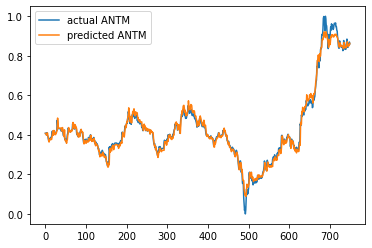

MSE training for ANTM : 0.0004653 



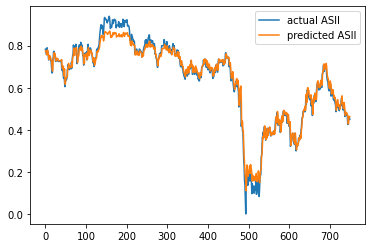

MSE training for ASII : 0.0008990 



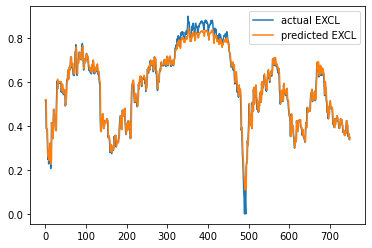

MSE training for EXCL : 0.0010960 



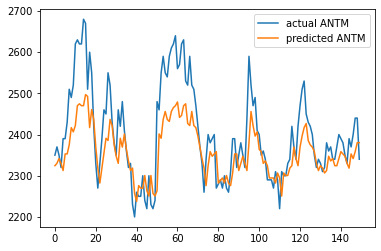

MSE testing for ANTM : 0.0002190


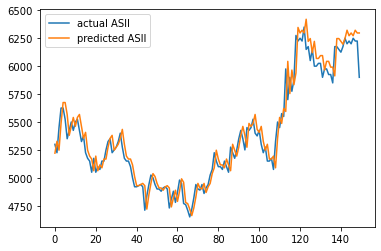

MSE testing for ASII : 0.0004223


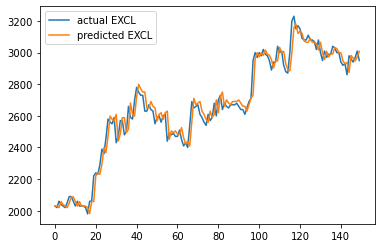

MSE testing for EXCL : 0.0004927


In [12]:
#Training
alpha1 = 0.39 #learning rate
alpha2 = 0.009
alpha3 = 0.012

seed(300197)

epochs = 10000 #Learning process of 100,000
epoch = 5 #learning progress results will be displayed 5 times

tic = datetime.now()

y1hat = zeros([len(y1), epoch]) #output stored epoch times
Cost1 = zeros([epoch])  #cost function saved epoch times

y2hat = zeros([len(y2), epoch]) 
Cost2 = zeros([epoch])

y3hat = zeros([len(y3), epoch]) 
Cost3 = zeros([epoch])

i = 0

for j in range(epochs):
    #forward propagation 

    #first layer
    Z11 = X1@w10 #chemical reaction in layer 1
    A11 = 1/(1+exp(-Z11)) #electric current in the 1st layer

    Z21 = X2@w20 
    A21 = 1/(1+exp(-Z21))  
    
    Z31 = X3@w30 
    A31 = 1/(1+exp(-Z31))  
    
    #Backward propagation

    #first layer
    e1 = (y1-A11)/sqrt(len(y1))
    C1 = e1.T@e1
    delta11 = -e1*A11*(1-A11)
    dw10 = X1.T@delta11

    e2 = (y2-A21)/sqrt(len(y2))
    C2 = e2.T@e2
    delta21 = -e2*A21*(1-A21)
    dw20 = X2.T@delta21

    e3 = (y3-A31)/sqrt(len(y3))
    C3 = e3.T@e3
    delta31 = -e3*A31*(1-A31)
    dw30 = X3.T@delta31

    w10 -= alpha1*dw10
    w20 -= alpha2*dw20
    w30 -= alpha3*dw30

    if (j+1)%(epochs/epoch)==0:
        toc = datetime.now()
        y1hat[:,i]=A11.squeeze() #prediksi disimpan epoch kali
        Cost1[i] = C1
        print("Up to epoch-",j+1,", the MSE for ANTM is obtained as follows %8.7f"%C1, "with time",toc-tic)

        y2hat[:,i]=A21.squeeze() #prediksi disimpan epoch kali
        Cost2[i] = C2
        print("Up to epoch-",j+1,", the MSE for ASII is obtained as follows %8.7f"%C2, "with time",toc-tic)

        y3hat[:,i]=A31.squeeze() #prediksi disimpan epoch kali
        Cost3[i] = C3
        print("Up to epoch-",j+1,", the MSE for EXCL is obtained as follows %8.7f"%C3, "with time",toc-tic,"\n")

        i+=1

plt.plot(y1, label = 'actual ANTM')
plt.plot(A11, label = 'predicted ANTM')
plt.legend()
plt.show()
print('MSE training for ANTM : %8.7f' %C1,'\n')

plt.plot(y2, label = 'actual ASII')
plt.plot(A21, label = 'predicted ASII')
plt.legend()
plt.show()
print('MSE training for ASII : %8.7f' %C2,'\n')

plt.plot(y3, label = 'actual EXCL')
plt.plot(A31, label = 'predicted EXCL')
plt.legend()
plt.show()
print('MSE training for EXCL : %8.7f' %C3,'\n')

#Testing

Z11 = X1test@w10
y1testhat = 1/(1+exp(-Z11))

Z21 = X2test@w20
y2testhat = 1/(1+exp(-Z21))

Z31 = X3test@w30
y3testhat = 1/(1+exp(-Z31))

y1testo1b = exp(y1test*(ATmax-ATmin)+ATmin) #kembalikan data ke original unit (Rp)
y2testo1b = exp(y2test*(ASmax-ASmin)+ASmin)
y3testo1b = exp(y3test*(XLmax-XLmin)+XLmin)

y1testhato1b = exp(y1testhat*(ATmax-ATmin)+ATmin) #kembalikan data ke original unit (Rp)
y2testhato1b = exp(y2testhat*(ASmax-ASmin)+ASmin)
y3testhato1b = exp(y3testhat*(XLmax-XLmin)+XLmin)

plt.plot(y1testo1b, label ='actual ANTM')
plt.plot(y1testhato1b, label ='predicted ANTM')
plt.legend()
plt.show()
msetest1b = (y1test-y1testhat).T@(y1test-y1testhat)/len(y1test) #MSE semasa testing
print('MSE testing for ANTM : %7.7f'%msetest1b)

plt.plot(y2testo1b, label ='actual ASII')
plt.plot(y2testhato1b, label ='predicted ASII')
plt.legend()
plt.show()
msetest2b = (y2test-y2testhat).T@(y2test-y2testhat)/len(y2test) #MSE semasa testing
print('MSE testing for ASII : %7.7f'%msetest2b)


plt.plot(y3testo1b, label ='actual EXCL')
plt.plot(y3testhato1b, label ='predicted EXCL')
plt.legend()
plt.show()
msetest3b = (y3test-y3testhat).T@(y3test-y3testhat)/len(y3test) #MSE semasa testing
print('MSE testing for EXCL : %7.7f'%msetest3b)


From the output above, it can be seen that the performance generated by the model with sigmoid activation function is not as good as the model without activation function. Nevertheless, the model with sigmoid activation function still looks good enough to model stock price movements. Furthermore, it can be seen that the MSE of the model with sigmoid activation function on the testing data is smaller when compared to the training data. However, when compared to the MSE of the model without activation function, the MSE value of the model without activation function is smaller. is smaller. Thus, the single layer perceptron model without activation function is better than the model with activation function. model is better than the model with sigmoid activation function to model the ANTM, ASII, and EXCL stock price movements.

## Stock Price Modeling Using Multi Layer Perceptron

In this section, we will show the results of modeling the stock prices of ANTM, ASII, and EXCL using multi-layer perceptron. For the multi layer perceptron method, 3 cases will be used, the first using 1 hidden layer, the second uses 2 hidden layers, and the third uses 3 hidden layers. layer.

### 1  Hidden Layer

The first step is to determine the number of iterations, many neurons, and the learning rate (𝛼) value used for each stock price. The number of iterations is determined as many as 10,000 times and for each hidden layer there are 5 neurons. For the learning rate value, in the case of 1 hidden layer, $\alpha_1 = 0.68, \alpha_2 = 1$, and $\alpha_3 = 0.69$ were chosen. Furthermore, for each case, we will look for the value of the parameter 𝑤 for each layer using the training data. Once obtained, the parameter will be used to estimate today's stock price on the training data. The prediction results will be used to calculate the mean squared error (MSE) with the actual stock price for today.

Up to epoch- 2000 , the MSE for ANTM is obtained as follows 0.0005220 with time 0:00:01.942858
Up to epoch- 2000 , the MSE for ASII is obtained as follows 0.0007612 with time 0:00:01.942858
Up to epoch- 2000 , the MSE for EXCL is obtained as follows 0.0013482 with time 0:00:01.942858 

Up to epoch- 4000 , the MSE for ANTM is obtained as follows 0.0005081 with time 0:00:03.534903
Up to epoch- 4000 , the MSE for ASII is obtained as follows 0.0006968 with time 0:00:03.534903
Up to epoch- 4000 , the MSE for EXCL is obtained as follows 0.0011078 with time 0:00:03.534903 

Up to epoch- 6000 , the MSE for ANTM is obtained as follows 0.0004925 with time 0:00:04.607049
Up to epoch- 6000 , the MSE for ASII is obtained as follows 0.0006199 with time 0:00:04.607049
Up to epoch- 6000 , the MSE for EXCL is obtained as follows 0.0009847 with time 0:00:04.607049 

Up to epoch- 8000 , the MSE for ANTM is obtained as follows 0.0004723 with time 0:00:05.613592
Up to epoch- 8000 , the MSE for ASII is obta

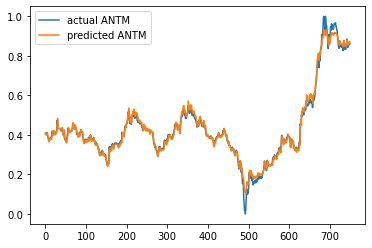

MSE training for ANTM : 0.0004529 



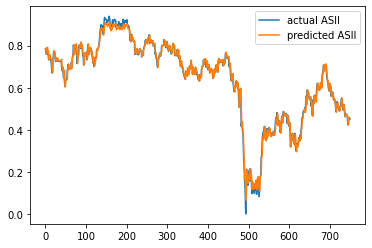

MSE training for ASII : 0.0005124 



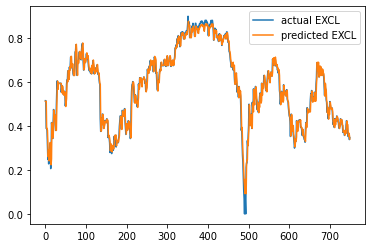

MSE training for EXCL : 0.0009390 



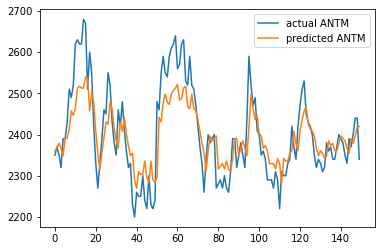

MSE testing for ANTM : 0.0001467


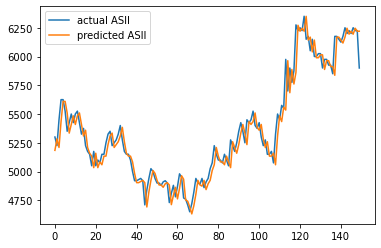

MSE testing for ASII : 0.0003951


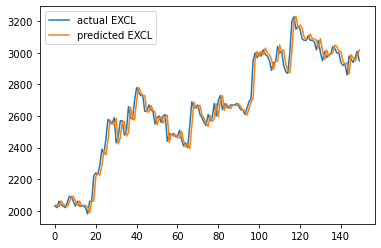

MSE testing for EXCL : 0.0005050


In [13]:
#Training
alpha1 = 0.68 #learning rate
alpha2 = 1
alpha3 = 0.69

H1 = 5 #Number of Neurons in hidden layer 1

seed(300197)

epochs = 10000 #Learning process of 100,000
epoch = 5 #learning progress results will be displayed 5 times

[N1, K1] = shape(X1)
[N2, K2] = shape(X2)
[N3, K3] = shape(X3)

w10 = randn(K1,H1) #initial value parameter w0
w20 = randn(K2,H1)
w30 = randn(K3,H1)

w11 = randn(H1,1) #initial value parameter w1
w21 = randn(H1,1)
w31 = randn(H1,1)

tic = datetime.now()

y1hat = zeros([len(y1), epoch]) #output stored epoch times
Cost1 = zeros([epoch])  #cost function saved epoch times

y2hat = zeros([len(y2), epoch]) 
Cost2 = zeros([epoch])

y3hat = zeros([len(y3), epoch]) 
Cost3 = zeros([epoch])

i = 0

for j in range(epochs):
    #forward propagation 

    #first layer
    Z11 = X1@w10 #chemical reaction in layer 1
    A11 = 1/(1+exp(-Z11)) #electric current in the 1st layer

    Z21 = X2@w20 
    A21 = 1/(1+exp(-Z21))  
    
    Z31 = X3@w30 
    A31 = 1/(1+exp(-Z31))

    #second layer
    Z12 = A11@w11 #chemical reaction in layer 2
    A12 = 1/(1+exp(-Z12)) #electric current in the 2nd layer

    Z22 = A21@w21 
    A22 = 1/(1+exp(-Z22))  
    
    Z32 = A31@w31 
    A32 = 1/(1+exp(-Z32))     
    
    #Backward propagation

    #second layer
    e1 = (y1-A12)/sqrt(len(y1))
    C1 = e1.T@e1
    delta12 = -e1*A12*(1-A12)
    dw11 = A11.T@delta12

    e2 = (y2-A22)/sqrt(len(y2))
    C2 = e2.T@e2
    delta22 = -e2*A22*(1-A22)
    dw21 = A21.T@delta22

    e3 = (y3-A32)/sqrt(len(y3))
    C3 = e3.T@e3
    delta32 = -e3*A32*(1-A32)
    dw31 = A31.T@delta32

    #first layer
    delta11 = delta12@w11.T*A11*(1-A11)
    dw10 = X1.T@delta11

    delta21 = delta22@w21.T*A21*(1-A21)
    dw20 = X2.T@delta21

    delta31 = delta32@w31.T*A31*(1-A31)
    dw30 = X3.T@delta31

    w11 -= alpha1*dw11
    w21 -= alpha2*dw21
    w31 -= alpha3*dw31

    w10 -= alpha1*dw10
    w20 -= alpha2*dw20
    w30 -= alpha3*dw30

    if (j+1)%(epochs/epoch)==0:
        toc = datetime.now()
        y1hat[:,i]=A12.squeeze() #prediction saved epoch times
        Cost1[i] = C1
        print("Up to epoch-",j+1,", the MSE for ANTM is obtained as follows %8.7f"%C1, "with time",toc-tic)

        y2hat[:,i]=A22.squeeze() #prediction saved epoch times
        Cost2[i] = C2
        print("Up to epoch-",j+1,", the MSE for ASII is obtained as follows %8.7f"%C2, "with time",toc-tic)

        y3hat[:,i]=A32.squeeze() #prediction saved epoch times
        Cost3[i] = C3
        print("Up to epoch-",j+1,", the MSE for EXCL is obtained as follows %8.7f"%C3, "with time",toc-tic,"\n")

        i+=1


plt.plot(y1, label = 'actual ANTM')
plt.plot(A12, label = 'predicted ANTM')
plt.legend()
plt.show()
print('MSE training for ANTM : %8.7f' %C1,'\n')

plt.plot(y2, label = 'actual ASII')
plt.plot(A22, label = 'predicted ASII')
plt.legend()
plt.show()
print('MSE training for ASII : %8.7f' %C2,'\n')

plt.plot(y3, label = 'actual EXCL')
plt.plot(A32, label = 'predicted EXCL')
plt.legend()
plt.show()
print('MSE training for EXCL : %8.7f' %C3,'\n')

#Testing'

#first layer
Z11 = X1test@w10
A11 = 1/(1+exp(-Z11))

Z21 = X2test@w20
A21 = 1/(1+exp(-Z21))

Z31 = X3test@w30
A31 = 1/(1+exp(-Z31))

#second layer
Z12 = A11@w11
y1testhat = 1/(1+exp(-Z12))

Z22 = A21@w21
y2testhat = 1/(1+exp(-Z22))

Z32 = A31@w31
y3testhat = 1/(1+exp(-Z32))

y1testo2 = exp(y1test*(ATmax-ATmin)+ATmin) #return data to original unit (Rp)
y2testo2 = exp(y2test*(ASmax-ASmin)+ASmin)
y3testo2 = exp(y3test*(XLmax-XLmin)+XLmin)

y1testhato2 = exp(y1testhat*(ATmax-ATmin)+ATmin) #return data to original unit (Rp)
y2testhato2 = exp(y2testhat*(ASmax-ASmin)+ASmin)
y3testhato2 = exp(y3testhat*(XLmax-XLmin)+XLmin)

plt.plot(y1testo2, label ='actual ANTM')
plt.plot(y1testhato2, label ='predicted ANTM')
plt.legend()
plt.show()
msetest12 = (y1test-y1testhat).T@(y1test-y1testhat)/len(y1test) #MSE during testing
print('MSE testing for ANTM : %7.7f'%msetest12)

plt.plot(y2testo2, label ='actual ASII')
plt.plot(y2testhato2, label ='predicted ASII')
plt.legend()
plt.show()
msetest22 = (y2test-y2testhat).T@(y2test-y2testhat)/len(y2test) #MSE during testing
print('MSE testing for ASII : %7.7f'%msetest22)

plt.plot(y3testo2, label ='actual EXCL')
plt.plot(y3testhato2, label ='predicted EXCL')
plt.legend()
plt.show()
msetest32 = (y3test-y3testhat).T@(y3test-y3testhat)/len(y3test) #MSE during testing
print('MSE testing for EXCL : %7.7f'%msetest32)




### 2 Hidden Layer

The first step is to determine the number of iterations, many neurons, and the learning rate (𝛼) value used for each stock price. The number of iterations is determined as many as 10,000 times and for each hidden layer there are 5 neurons. For the learning rate value, in the case of 2 hidden layer, $\alpha_1 = 0.577, \alpha_2 = 0.8$, and $\alpha_3 = 1.42$ were chosen. Furthermore, for each case, we will look for the value of the parameter 𝑤 for each layer using the training data. Once obtained, the parameter will be used to estimate today's stock price on the training data. The prediction results will be used to calculate the mean squared error (MSE) with the actual stock price for today.

Up to epoch- 2000 , the MSE for ANTM is obtained as follows 0.0007179 with time 0:00:01.871282
Up to epoch- 2000 , the MSE for ASII is obtained as follows 0.0006657 with time 0:00:01.871282
Up to epoch- 2000 , the MSE for EXCL is obtained as follows 0.0009686 with time 0:00:01.871282 

Up to epoch- 4000 , the MSE for ANTM is obtained as follows 0.0005185 with time 0:00:03.561344
Up to epoch- 4000 , the MSE for ASII is obtained as follows 0.0005245 with time 0:00:03.561344
Up to epoch- 4000 , the MSE for EXCL is obtained as follows 0.0009258 with time 0:00:03.561344 

Up to epoch- 6000 , the MSE for ANTM is obtained as follows 0.0003959 with time 0:00:04.835650
Up to epoch- 6000 , the MSE for ASII is obtained as follows 0.0004976 with time 0:00:04.835650
Up to epoch- 6000 , the MSE for EXCL is obtained as follows 0.0009240 with time 0:00:04.835650 

Up to epoch- 8000 , the MSE for ANTM is obtained as follows 0.0003361 with time 0:00:06.255868
Up to epoch- 8000 , the MSE for ASII is obta

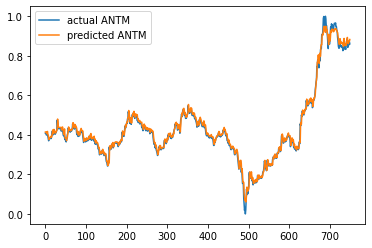

MSE training for ANTM : 0.0003147 



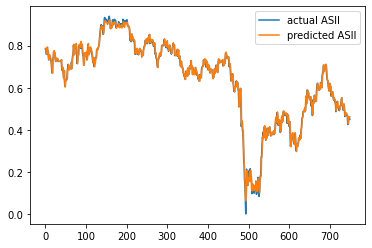

MSE training for ASII : 0.0004903 



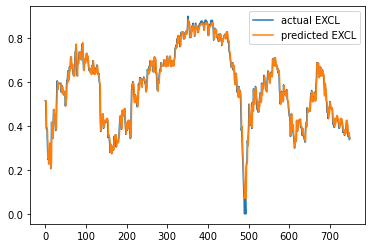

MSE training for EXCL : 0.0009228 



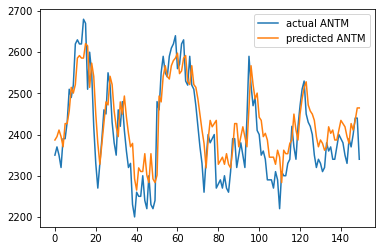

MSE testing for ANTM : 0.0001464


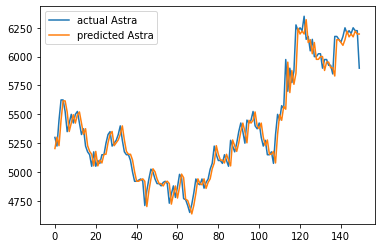

MSE testing for ASII : 0.0003803


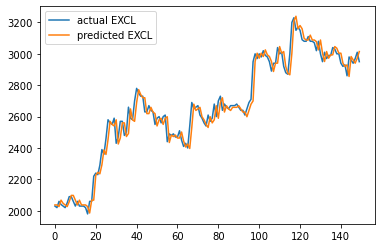

MSE testing for EXCL : 0.0005036


In [14]:
#Training
alpha1 = 0.577 #learning rate
alpha2 = 0.8
alpha3 = 1.42 

H1 = 5 #Number of Neurons in hidden layer 1
H2 = 5 #Number of Neurons in hidden layer 2

seed(300197)

epochs = 10000 #Learning process of 100,000 
epoch = 5 #learning progress results will be displayed 5 times

[N1, K1] = shape(X1)
[N2, K2] = shape(X2)
[N3, K3] = shape(X3)

w10 = randn(K1,H1) #initial value parameter w0
w20 = randn(K2,H1)
w30 = randn(K3,H1)

w11 = randn(H1,H2) #initial value parameter w1
w21 = randn(H1,H2)
w31 = randn(H1,H2)

w12 = randn(H2,1) #initial value parameter w2
w22 = randn(H2,1)
w32 = randn(H2,1)

tic = datetime.now()

y1hat = zeros([len(y1), epoch]) #output stored epoch times
Cost1 = zeros([epoch])  #cost function saved epoch times

y2hat = zeros([len(y2), epoch]) 
Cost2 = zeros([epoch])

y3hat = zeros([len(y3), epoch]) 
Cost3 = zeros([epoch])

i = 0

for j in range(epochs):
    #forward propagation 

    #first layer
    Z11 = X1@w10 #chemical reaction in layer 1
    A11 = 1/(1+exp(-Z11)) #electric current in the 1st layer

    Z21 = X2@w20 
    A21 = 1/(1+exp(-Z21))  
    
    Z31 = X3@w30 
    A31 = 1/(1+exp(-Z31))

    #second layer
    Z12 = A11@w11 #chemical reaction in layer 2
    A12 = 1/(1+exp(-Z12)) #electric current in the 2nd layer

    Z22 = A21@w21 
    A22 = 1/(1+exp(-Z22))  
    
    Z32 = A31@w31 
    A32 = 1/(1+exp(-Z32))

    #Third layer
    Z13 = A12@w12 #chemical reaction in layer 3
    A13 = 1/(1+exp(-Z13)) #electric current in the 3rd layer

    Z23 = A22@w22 
    A23 = 1/(1+exp(-Z23))  
    
    Z33 = A32@w32 
    A33 = 1/(1+exp(-Z33))     
    
    #Backward propagation

    #Third layer
    e1 = (y1-A13)/sqrt(len(y1))
    C1 = e1.T@e1
    delta13 = -e1*A13*(1-A13)
    dw12 = A12.T@delta13

    e2 = (y2-A23)/sqrt(len(y2))
    C2 = e2.T@e2
    delta23 = -e2*A23*(1-A23)
    dw22 = A22.T@delta23

    e3 = (y3-A33)/sqrt(len(y3))
    C3 = e3.T@e3
    delta33 = -e3*A33*(1-A33)
    dw32 = A32.T@delta33

    #Second layer
    delta12 = delta13@w12.T*A12*(1-A12)
    dw11 = A11.T@delta12

    delta22 = delta23@w22.T*A22*(1-A22)
    dw21 = A21.T@delta22

    delta32 = delta33@w32.T*A32*(1-A32)
    dw31 = A31.T@delta32

    #first layer
    delta11 = delta12@w11.T*A11*(1-A11)
    dw10 = X1.T@delta11

    delta21 = delta22@w21.T*A21*(1-A21)
    dw20 = X2.T@delta21

    delta31 = delta32@w31.T*A31*(1-A31)
    dw30 = X3.T@delta31

    w12 -= alpha1*dw12
    w22 -= alpha2*dw22
    w32 -= alpha3*dw32

    w11 -= alpha1*dw11
    w21 -= alpha2*dw21
    w31 -= alpha3*dw31

    w10 -= alpha1*dw10
    w20 -= alpha2*dw20
    w30 -= alpha3*dw30

    if (j+1)%(epochs/epoch)==0:
        toc = datetime.now()
        y1hat[:,i]=A13.squeeze() #prediction saved epoch times
        Cost1[i] = C1
        print("Up to epoch-",j+1,", the MSE for ANTM is obtained as follows %8.7f"%C1, "with time",toc-tic)

        y2hat[:,i]=A23.squeeze() #prediction saved epoch times
        Cost2[i] = C2
        print("Up to epoch-",j+1,", the MSE for ASII is obtained as follows %8.7f"%C2, "with time",toc-tic)

        y3hat[:,i]=A33.squeeze() #prediction saved epoch times
        Cost3[i] = C3
        print("Up to epoch-",j+1,", the MSE for EXCL is obtained as follows %8.7f"%C3, "with time",toc-tic,"\n")

        i+=1
        
plt.plot(y1, label = 'actual ANTM')
plt.plot(A13, label = 'predicted ANTM')
plt.legend()
plt.show()
print('MSE training for ANTM : %8.7f' %C1,'\n')

plt.plot(y2, label = 'actual ASII')
plt.plot(A23, label = 'predicted ASII')
plt.legend()
plt.show()
print('MSE training for ASII : %8.7f' %C2,'\n')

plt.plot(y3, label = 'actual EXCL')
plt.plot(A33, label = 'predicted EXCL')
plt.legend()
plt.show()
print('MSE training for EXCL : %8.7f' %C3,'\n')

#Testing

#first layer
Z11 = X1test@w10
A11 = 1/(1+exp(-Z11))

Z21 = X2test@w20
A21 = 1/(1+exp(-Z21))

Z31 = X3test@w30
A31 = 1/(1+exp(-Z31))

#second layer
Z12 = A11@w11
A12 = 1/(1+exp(-Z12))

Z22 = A21@w21
A22 = 1/(1+exp(-Z22))

Z32 = A31@w31
A32 = 1/(1+exp(-Z32))

#third layer
Z13 = A12@w12
y1testhat = 1/(1+exp(-Z13))

Z23 = A22@w22
y2testhat = 1/(1+exp(-Z23))

Z33 = A32@w32
y3testhat = 1/(1+exp(-Z33))

y1testo3 = exp(y1test*(ATmax-ATmin)+ATmin) #kembalikan data ke original unit (Rp)
y2testo3 = exp(y2test*(ASmax-ASmin)+ASmin)
y3testo3 = exp(y3test*(XLmax-XLmin)+XLmin)

y1testhato3 = exp(y1testhat*(ATmax-ATmin)+ATmin) #kembalikan data ke original unit (Rp)
y2testhato3 = exp(y2testhat*(ASmax-ASmin)+ASmin)
y3testhato3 = exp(y3testhat*(XLmax-XLmin)+XLmin)

plt.plot(y1testo3, label ='actual ANTM')
plt.plot(y1testhato3, label ='predicted ANTM')
plt.legend()
plt.show()
msetest13 = (y1test-y1testhat).T@(y1test-y1testhat)/len(y1test) #MSE during testing
print('MSE testing for ANTM : %7.7f'%msetest13)

plt.plot(y2testo3, label ='actual Astra')
plt.plot(y2testhato3, label ='predicted Astra')
plt.legend()
plt.show()
msetest23 = (y2test-y2testhat).T@(y2test-y2testhat)/len(y2test) #MSE during testing
print('MSE testing for ASII : %7.7f'%msetest23)

plt.plot(y3testo3, label ='actual EXCL')
plt.plot(y3testhato3, label ='predicted EXCL')
plt.legend()
plt.show()
msetest33 = (y3test-y3testhat).T@(y3test-y3testhat)/len(y3test) #MSE during testing
print('MSE testing for EXCL : %7.7f'%msetest33)


### 3 Hidden Layer

The first step is to determine the number of iterations, many neurons, and the learning rate (𝛼) value used for each stock price. The number of iterations is determined as many as 10,000 times and for each hidden layer there are 5 neurons. For the learning rate value, in the case of 3 hidden layer, $\alpha_1 = \alpha_2 = 0.5$, and $\alpha_3 = 0.65$ were chosen. Furthermore, for each case, we will look for the value of the parameter 𝑤 for each layer using the training data. Once obtained, the parameter will be used to estimate today's stock price on the training data. The prediction results will be used to calculate the mean squared error (MSE) with the actual stock price for today.

Up to epoch- 2000 , the MSE for ANTM is obtained as follows 0.0011992 with time 0:00:01.965894
Up to epoch- 2000 , the MSE for ASII is obtained as follows 0.0011783 with time 0:00:01.965894
Up to epoch- 2000 , the MSE for EXCL is obtained as follows 0.0014286 with time 0:00:01.965894 

Up to epoch- 4000 , the MSE for ANTM is obtained as follows 0.0006573 with time 0:00:03.810653
Up to epoch- 4000 , the MSE for ASII is obtained as follows 0.0007888 with time 0:00:03.810653
Up to epoch- 4000 , the MSE for EXCL is obtained as follows 0.0011533 with time 0:00:03.810653 

Up to epoch- 6000 , the MSE for ANTM is obtained as follows 0.0004791 with time 0:00:05.785195
Up to epoch- 6000 , the MSE for ASII is obtained as follows 0.0005272 with time 0:00:05.785195
Up to epoch- 6000 , the MSE for EXCL is obtained as follows 0.0010297 with time 0:00:05.785195 

Up to epoch- 8000 , the MSE for ANTM is obtained as follows 0.0003985 with time 0:00:07.777314
Up to epoch- 8000 , the MSE for ASII is obta

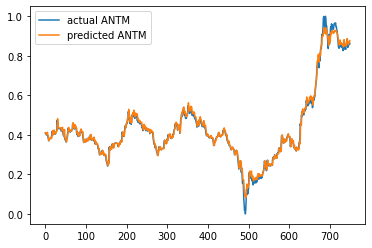

MSE training for ANTM : 0.0003514 



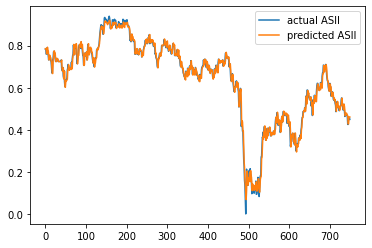

MSE training for ASII : 0.0004889 



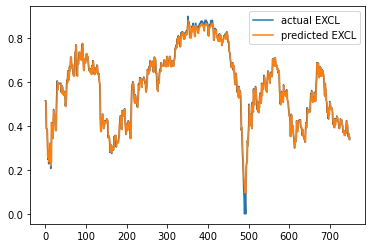

MSE training for EXCL : 0.0009365 



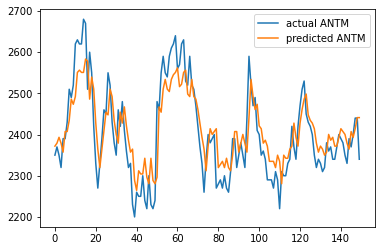

MSE testing for ASII : 0.0001288


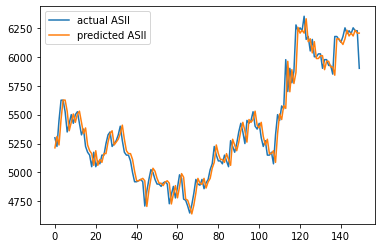

MSE testing for ASII : 0.0003779


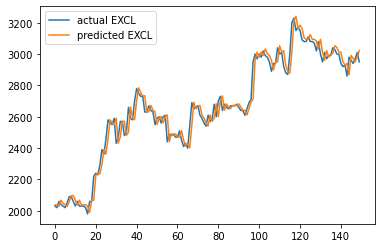

MSE testing for EXCL : 0.0004929


In [15]:
#Training
alpha1 = 0.5 #learning rate
alpha2 = 0.5
alpha3 = 0.65

H1 = 5 #Number of Neurons in hidden layer 1
H2 = 5 #Number of Neurons in hidden layer 2
H3 = 5 #Number of Neurons in hidden layer 3

seed(300197)

epochs = 10000 #Learning process of 100,000
epoch = 5 #learning progress results will be displayed 5 times

[N1, K1] = shape(X1)
[N2, K2] = shape(X2)
[N3, K3] = shape(X3)

w10 = randn(K1,H1) #initial value parameter w0
w20 = randn(K2,H1)
w30 = randn(K3,H1)

w11 = randn(H1,H2) #initial value parameter w1
w21 = randn(H1,H2)
w31 = randn(H1,H2)

w12 = randn(H2,H3) #initial value parameter w2
w22 = randn(H2,H3)
w32 = randn(H2,H3)

w13 = randn(H3,1) #initial value parameter w3
w23 = randn(H3,1)
w33 = randn(H3,1)

tic = datetime.now()

y1hat = zeros([len(y1), epoch]) #output stored epoch times
Cost1 = zeros([epoch])  #cost function saved epoch times

y2hat = zeros([len(y2), epoch]) 
Cost2 = zeros([epoch])

y3hat = zeros([len(y3), epoch]) 
Cost3 = zeros([epoch])

i = 0

for j in range(epochs):
    #forward propagation 

    #first layer
    Z11 = X1@w10 #chemical reaction in layer 1
    A11 = 1/(1+exp(-Z11)) #electric current in the 1st layer

    Z21 = X2@w20 
    A21 = 1/(1+exp(-Z21))  
    
    Z31 = X3@w30 
    A31 = 1/(1+exp(-Z31))

    #second layer
    Z12 = A11@w11 #chemical reaction in layer 2
    A12 = 1/(1+exp(-Z12)) #electric current in the 2nd layer

    Z22 = A21@w21 
    A22 = 1/(1+exp(-Z22))  
    
    Z32 = A31@w31 
    A32 = 1/(1+exp(-Z32))

    #Third layer
    Z13 = A12@w12 #chemical reaction in layer 3
    A13 = 1/(1+exp(-Z13)) #electric current in the 3rd layer

    Z23 = A22@w22 
    A23 = 1/(1+exp(-Z23))  
    
    Z33 = A32@w32 
    A33 = 1/(1+exp(-Z33)) 

    #Fourth layer
    Z14 = A13@w13 #chemical reaction in layer 4
    A14 = 1/(1+exp(-Z14)) #electric current in the 4th layer

    Z24 = A23@w23 
    A24 = 1/(1+exp(-Z24))  
    
    Z34 = A33@w33 
    A34 = 1/(1+exp(-Z34))     
    
    #Backward propagation

    #Fourth layer
    e1 = (y1-A14)/sqrt(len(y1))
    C1 = e1.T@e1
    delta14 = -e1*A14*(1-A14)
    dw13 = A13.T@delta14

    e2 = (y2-A24)/sqrt(len(y2))
    C2 = e2.T@e2
    delta24 = -e2*A24*(1-A24)
    dw23 = A23.T@delta24

    e3 = (y3-A34)/sqrt(len(y3))
    C3 = e3.T@e3
    delta34 = -e3*A34*(1-A34)
    dw33 = A33.T@delta34

    #Third layer
    delta13 = delta14@w13.T*A13*(1-A13)
    dw12 = A12.T@delta13

    delta23 = delta24@w23.T*A23*(1-A23)
    dw22 = A22.T@delta23

    delta33 = delta34@w33.T*A33*(1-A33)
    dw32 = A32.T@delta33

    #Second layer
    delta12 = delta13@w12.T*A12*(1-A12)
    dw11 = A11.T@delta12

    delta22 = delta23@w22.T*A22*(1-A22)
    dw21 = A21.T@delta22

    delta32 = delta33@w32.T*A32*(1-A32)
    dw31 = A31.T@delta32

    #first layer
    delta11 = delta12@w11.T*A11*(1-A11)
    dw10 = X1.T@delta11

    delta21 = delta22@w21.T*A21*(1-A21)
    dw20 = X2.T@delta21

    delta31 = delta32@w31.T*A31*(1-A31)
    dw30 = X3.T@delta31

    w13 -= alpha1*dw13
    w23 -= alpha2*dw23
    w33 -= alpha3*dw33

    w12 -= alpha1*dw12
    w22 -= alpha2*dw22
    w32 -= alpha3*dw32

    w11 -= alpha1*dw11
    w21 -= alpha2*dw21
    w31 -= alpha3*dw31

    w10 -= alpha1*dw10
    w20 -= alpha2*dw20
    w30 -= alpha3*dw30

    if (j+1)%(epochs/epoch)==0:
        toc = datetime.now()
        y1hat[:,i]=A14.squeeze() #prediction saved epoch times
        Cost1[i] = C1
        print("Up to epoch-",j+1,", the MSE for ANTM is obtained as follows %8.7f"%C1, "with time",toc-tic)

        y2hat[:,i]=A24.squeeze() #prediction saved epoch times
        Cost2[i] = C2
        print("Up to epoch-",j+1,", the MSE for ASII is obtained as follows %8.7f"%C2, "with time",toc-tic)

        y3hat[:,i]=A34.squeeze() #prediction saved epoch times
        Cost3[i] = C3
        print("Up to epoch-",j+1,", the MSE for EXCL is obtained as follows %8.7f"%C3, "with time",toc-tic,"\n")

        i+=1

plt.plot(y1, label = 'actual ANTM')
plt.plot(A14, label = 'predicted ANTM')
plt.legend()
plt.show()
print('MSE training for ANTM : %8.7f' %C1,'\n')

plt.plot(y2, label = 'actual ASII')
plt.plot(A24, label = 'predicted ASII')
plt.legend()
plt.show()
print('MSE training for ASII : %8.7f' %C2,'\n')

plt.plot(y3, label = 'actual EXCL')
plt.plot(A34, label = 'predicted EXCL')
plt.legend()
plt.show()
print('MSE training for EXCL : %8.7f' %C3,'\n')

'Testing'

#first layer
Z11 = X1test@w10
A11 = 1/(1+exp(-Z11))

Z21 = X2test@w20
A21 = 1/(1+exp(-Z21))

Z31 = X3test@w30
A31 = 1/(1+exp(-Z31))

#second layer
Z12 = A11@w11
A12 = 1/(1+exp(-Z12))

Z22 = A21@w21
A22 = 1/(1+exp(-Z22))

Z32 = A31@w31
A32 = 1/(1+exp(-Z32))

#third layer
Z13 = A12@w12
A13 = 1/(1+exp(-Z13))

Z23 = A22@w22
A23 = 1/(1+exp(-Z23))

Z33 = A32@w32
A33 = 1/(1+exp(-Z33))

#Fourth Layer
Z14 = A13@w13
y1testhat = 1/(1+exp(-Z14))

Z24 = A23@w23
y2testhat = 1/(1+exp(-Z24))

Z34 = A33@w33
y3testhat = 1/(1+exp(-Z34))

y1testo4 = exp(y1test*(ATmax-ATmin)+ATmin) #return data to original unit (Rp)
y2testo4 = exp(y2test*(ASmax-ASmin)+ASmin)
y3testo4 = exp(y3test*(XLmax-XLmin)+XLmin)

y1testhato4 = exp(y1testhat*(ATmax-ATmin)+ATmin) #return data to original unit (Rp)
y2testhato4 = exp(y2testhat*(ASmax-ASmin)+ASmin)
y3testhato4 = exp(y3testhat*(XLmax-XLmin)+XLmin)

plt.plot(y1testo4, label ='actual ANTM')
plt.plot(y1testhato4, label ='predicted ANTM')
plt.legend()
plt.show()
msetest14 = (y1test-y1testhat).T@(y1test-y1testhat)/len(y1test) #MSE during testing
print('MSE testing for ASII : %7.7f'%msetest14)

plt.plot(y2testo4, label ='actual ASII')
plt.plot(y2testhato4, label ='predicted ASII')
plt.legend()
plt.show()
msetest24 = (y2test-y2testhat).T@(y2test-y2testhat)/len(y2test) #MSE during testing
print('MSE testing for ASII : %7.7f'%msetest24)

plt.plot(y3testo4, label ='actual EXCL')
plt.plot(y3testhato4, label ='predicted EXCL')
plt.legend()
plt.show()
msetest34 = (y3test-y3testhat).T@(y3test-y3testhat)/len(y3test) #MSE during testing
print('MSE testing for EXCL : %7.7f'%msetest34)


From the output obtained, it can be seen that for ANTM and EXCL stocks, when the number of hidden layers is increased, the MSE value does not necessarily decrease. This shows that the more complicated a model does not guarantee the results will be better. Sometimes a simple model is more capable in estimating stock price movements. 

Another factor that causes the MSE value to fluctuate is that the learning process has not yet converged. This can be overcome by increasing number of iterations or determining the appropriate learning rate. Apart from fluctuations in the MSE value, in general, the MSE of the three stock prices is quite small, so it can be stated that the model works well in modeling stock price movements.